In [1]:
%pip install river pandas==2.2.2 scipy==1.13.1 numpy==1.26.1


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib yfinance matplotlib yfinance numpy scikit-learn river scikit-optimize pysqlite3


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from river import metrics

# Importando as classes refatoradas
from utils.SeriesProcessor import SeriesProcessor
from utils.ModelTrainer import ModelTrainer
from utils.DriftEvaluator import DriftEvaluator
from utils.Visualizer import Visualizer
from utils.Optimizer import Optimizer

# Importando as classes existentes de otimização
from classes.otimizador.OtimizadorBayesiano import OtimizadorBayesiano

# 1. Importar os modelos e detectores de drift

In [4]:
# Importando detectores de drift
from classes.detectores.ADWINDetector import ADWINDetector
from classes.detectores.DDMDetector import DDMDetector
from classes.detectores.EDDMDetector import EDDMDetector
from classes.detectores.FHDDMDetector import FHDDMDetector
from classes.detectores.HDDM_ADetector import HDDM_ADetector
from classes.detectores.PageHinkleyDetector import PageHinkleyDetector
from classes.detectores.HDDM_WDetector import HDDM_WDetector
#from classes.detectores.KSWINDetector import KSWINDetector

# Importando modelos offline
from classes.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from classes.modelosOffline.KneighborsRegressorModelo import KNeighborsRegressorModelo
from classes.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from classes.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from classes.modelosOffline.SVRModelo import SVRModelo
from classes.modelosOffline.RandomForestModelo import RandomForestModelo
from classes.modelosOffline.MLPRegressorModelo import MLPRegressorModelo

# Importando modelos online
from classes.modelosOnline.BayesianLinearRegressionModelo import BayesianLinearRegressionModelo
from classes.modelosOnline.HoeffdingTreeRegressorModelo import HoeffdingTreeRegressorModelo
from classes.modelosOnline.KNNRegressorOnlineModelo import KNNRegressorOnlineModelo
from classes.modelosOnline.LinearRegressionOnlineModelo import LinearRegressionOnlineModelo

# 2. Baixar e preparar os dados

In [5]:
# Lista de séries temporais disponíveis
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

In [6]:
# Definindo parâmetros para processamento
tamanho_batch = 50
lags = 5
serie_escolhida = series[-2]
print(f"Processando série: {serie_escolhida}")

# Baixando os dados da ação
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal.shape}")

# Gerando janelas temporais
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal, lags)
print(f"Shape dos dados de entrada: {X.shape}")
print(f"Shape dos dados de saída: {Y.shape}")

Processando série: ^BVSP
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1244, 1)
Shape dos dados de entrada: (1239, 5)
Shape dos dados de saída: (1239, 1)


# 3. Otimização de Hiperparâmetros

In [7]:
# Lista de modelos a otimizar (classes)
modelos_offline = [
    LinearRegressionModelo,
    KNeighborsRegressorModelo,
    LassoRegressionModelo,
    #MLPRegressorModelo,  # Comentado por ser mais lento
    RandomForestModelo,
    RidgeRegressionModelo,
    SVRModelo
]

modelos_online = [
    BayesianLinearRegressionModelo,
    HoeffdingTreeRegressorModelo,
    KNNRegressorOnlineModelo,
    LinearRegressionOnlineModelo
]

# Inicializar o otimizador
optimizer = OtimizadorBayesiano(n_iter=20, cv=3, random_state=42)

# Otimizando todos os modelos
modelos_otimizados, parametros_otimizados = Optimizer.otimizar_todos_modelos(
    X, Y, tamanho_batch, lags=lags, optimizer=optimizer,
    modelos_offline=modelos_offline,
    modelos_online=modelos_online
)

# Salvar parâmetros otimizados para uso futuro
import json
with open('parametros_otimizados.json', 'w') as f:
    # Converter valores não serializáveis para strings
    params_serializaveis = {}
    for modelo, params in parametros_otimizados.items():
        params_serializaveis[modelo] = {k: str(v) for k, v in params.items()}
    json.dump(params_serializaveis, f, indent=4)

print("Parâmetros otimizados salvos em 'parametros_otimizados.json'")


Otimizando LinearRegressionModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [False, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, False] before, using random point [True, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [True, False, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, False] before, using random point [True, True, True]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [False, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [True, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, True, False] before, using random point [False, False, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [False, False, False] before, using random point [True, False, True]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, True, False] before, using random point [True, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits

Otimizando KNeighborsRegressorModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.790e-01, tolerance: 5.702e-04
  model = cd_fast.enet_coordinate_descent(
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.510e+00, tolerance: 9.777e-04
  model = cd_fast.enet_coordinate_descent(
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Otimizando RandomForestModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector 


Otimizando RidgeRegressionModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v

Espaço de parâmetros não definido para BayesianLinearRegressionModelo
Espaço de parâmetros não definido para HoeffdingTreeRegressorModelo
Espaço de parâmetros não definido para KNNRegressorOnlineModelo
Espaço de parâmetros não definido para LinearRegressionOnlineModelo
Parâmetros otimizados salvos em 'parametros_otimizados.json'


# 4. Executando Avaliação Prequential com Detecção de Drift

In [8]:
# Detector de drift a ser usado
detector_escolhido = ADWINDetector

# Executando prequential com os modelos otimizados
resultados = {}
deteccoes_por_modelo = {}

for nome_modelo, modelo in modelos_otimizados.items():
    print(f"\nExecutando prequential para {nome_modelo}...")
    predicoes, deteccoes = DriftEvaluator.prequential_batch(X, Y, tamanho_batch, modelo_classe=type(modelo), detector_classe=detector_escolhido)
    resultados[nome_modelo] = predicoes
    deteccoes_por_modelo[nome_modelo] = deteccoes  # Armazena as detecções

    print(f"Número de detecções para {nome_modelo}: {len(deteccoes)}")


Executando prequential para LinearRegressionModelo...
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7e7dd500e6f0>
MAE Modelo Batch: [0.08969106]
Desvio Padrão dos Erros: 0.07158972933625318
Número de detecções para LinearRegressionModelo: 0

Executando prequential para KNeighborsRegressorModelo...

Mudança detectada no índice 208, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 207 até 257.

Mudança detectada no índice 480, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 479 até 529.

Mudança detectada no índice 976, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 975 até 1025.
Modelo utilizado: <classes.modelosOffline.KneighborsRegressorModelo.KNeighborsRegressorModelo object at 0x7e7dd5160bf0>
Detector utilizado: <classes.detectores.

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 208, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 207 até 257.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 480, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 479 até 529.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 976, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 975 até 1025.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7e7dd4a0e6f0>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7e7dd4737830>
MAE Modelo Batch: 0.45217015355293205
Desvio Padrão dos Erros: 0.5283543498325625
Número de detecções para RandomForestModelo: 3

Executando prequential para RidgeRegressionModelo...
Modelo utilizado: <classes.modelosOffline.RidgeRegressionModelo.RidgeRegressionModelo object at 0x7e7dd46b7f20>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7e7dd46b6750>
MAE Modelo Batch: 0.09947534620889169
Desvio Padrão dos Erros: 0.07623950710889038
Número de detecções para RidgeRegressionModelo: 0

Executando prequential para SVRModelo...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v


Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.

Mudança detectada no índice 448, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 447 até 497.

Mudança detectada no índice 656, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 655 até 705.

Mudança detectada no índice 928, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 927 até 977.
Modelo utilizado: <classes.modelosOffline.SVRModelo.SVRModelo object at 0x7e7dd46b5910>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7e7dd46b5940>
MAE Modelo Batch: 0.6711700688536041
Desvio Padrão dos Erros: 0.6912980163280055
Número de detecções para SVRModelo: 4


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Nenhum drift detectado para LinearRegressionModelo.

Drift detectado para KNeighborsRegressorModelo nos índices: [208, 480, 976]

Nenhum drift detectado para LassoRegressionModelo.

Drift detectado para RandomForestModelo nos índices: [208, 480, 976]

Nenhum drift detectado para RidgeRegressionModelo.

Drift detectado para SVRModelo nos índices: [176, 448, 656, 928]


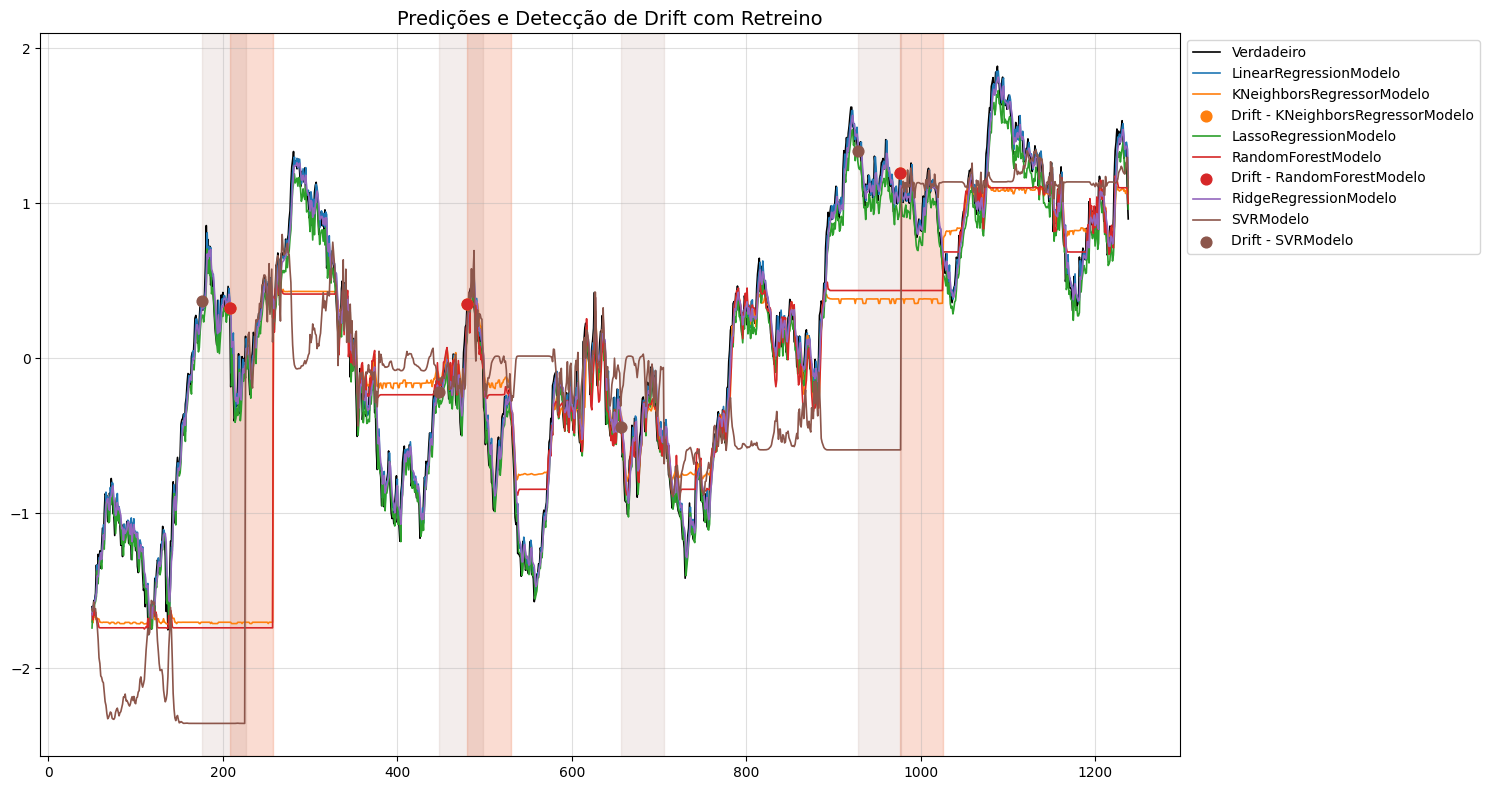

In [9]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  list(resultados.values()),
                  list(resultados.keys()),
                  deteccoes_por_modelo,
                  tamanho_batch)

# 5. Comparação de Detectores de Drift

In [10]:
# Selecionando um modelo para testar com diferentes detectores
modelo_escolhido = RandomForestModelo
print(f"Modelo selecionado para testes comparativos: {modelo_escolhido.__name__}")

# Lista de detectores a testar
detectores = [
    ADWINDetector,
    DDMDetector,
    EDDMDetector,
    FHDDMDetector,
    HDDM_ADetector,
    PageHinkleyDetector
]

resultados_detectores = {}
deteccoes_detectores = {}

for detector in detectores:
    nome_detector = detector.__name__
    print(f"\nTestando {nome_detector}...")
    predicoes, deteccoes = DriftEvaluator.prequential_batch(X, Y, tamanho_batch, modelo_classe=modelo_escolhido, detector_classe=detector)
    resultados_detectores[nome_detector] = predicoes
    deteccoes_detectores[nome_detector] = deteccoes
    print(f"Número de detecções para {nome_detector}: {len(deteccoes)}")

Modelo selecionado para testes comparativos: RandomForestModelo

Testando ADWINDetector...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 208, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 207 até 257.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 480, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 479 até 529.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 976, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 975 até 1025.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7e7dd1b8b9e0>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7e7dd1bbff50>
MAE Modelo Batch: 0.45217015355293205
Desvio Padrão dos Erros: 0.5283543498325625
Número de detecções para ADWINDetector: 3

Testando DDMDetector...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 463, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 462 até 512.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1006, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1005 até 1055.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7e7dd1b86c60>
Detector utilizado: <classes.detectores.DDMDetector.DDMDetector object at 0x7e7dd1bbe780>
MAE Modelo Batch: 0.7529776815977263
Desvio Padrão dos Erros: 0.7916489437869072
Número de detecções para DDMDetector: 2

Testando EDDMDetector...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7e7dd1b94800>
Detector utilizado: <classes.detectores.EDDMDetector.EDDMDetector object at 0x7e7dd4953f80>
MAE Modelo Batch: 1.8512156404941422
Desvio Padrão dos Erros: 0.8572211343121731
Número de detecções para EDDMDetector: 0

Testando FHDDMDetector...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 378, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 377 até 427.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 746, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 745 até 795.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1192, começando a coletar dados para retreino...
Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7e7dd1b7af60>
Detector utilizado: <classes.detectores.FHDDMDetector.FHDDMDetector object at 0x7e7dd1bbd130>
MAE Modelo Batch: 0.8278378570139742
Desvio Padrão dos Erros: 0.7214516338902226
Número de detecções para FHDDMDetector: 3

Testando HDDM_ADetector...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 154, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 153 até 203.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1122, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1121 até 1171.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7e7dd1d00cb0>
Detector utilizado: <classes.detectores.HDDM_ADetector.HDDM_ADetector object at 0x7e7dd1bbe210>
MAE Modelo Batch: 0.41457267769352973
Desvio Padrão dos Erros: 0.43649806260513035
Número de detecções para HDDM_ADetector: 2

Testando PageHinkleyDetector...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 189, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 188 até 238.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1004, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1003 até 1053.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7e7dd1bbc6e0>
Detector utilizado: <classes.detectores.PageHinkleyDetector.PageHinkleyDetector object at 0x7e7dd1bbdc40>
MAE Modelo Batch: 0.4998484284203495
Desvio Padrão dos Erros: 0.5021848384939026
Número de detecções para PageHinkleyDetector: 2



Drift detectado para ADWINDetector nos índices: [208, 480, 976]

Drift detectado para DDMDetector nos índices: [463, 1006]

Nenhum drift detectado para EDDMDetector.

Drift detectado para FHDDMDetector nos índices: [378, 746, 1192]

Drift detectado para HDDM_ADetector nos índices: [154, 1122]

Drift detectado para PageHinkleyDetector nos índices: [189, 1004]


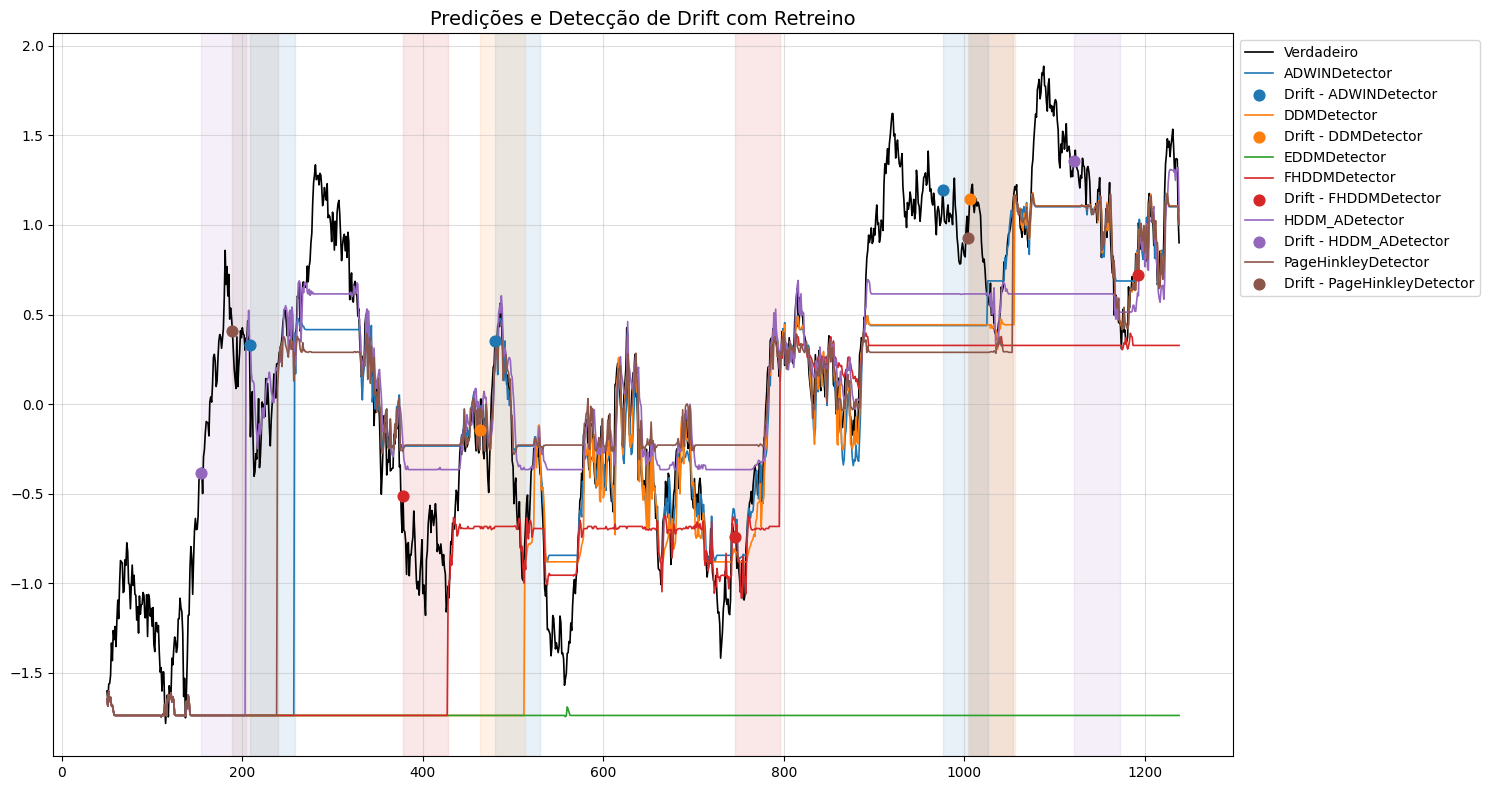

In [11]:
# Plotando comparação de detectores
Visualizer.plotar_resultados_multi(Y,
                  list(resultados_detectores.values()),
                  list(resultados_detectores.keys()),
                  deteccoes_detectores,
                  tamanho_batch)